In [1]:
# basic set of imports
import re, operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

from collections import defaultdict
from IPython.display import display, HTML
import datetime, pickle
import time
import tables
import csv
%matplotlib inline

In [2]:
datasets = ["test","train"]

In [26]:
# parser functions
# dateutil.parser.parse(timestr, parserinfo=None, **kwargs)
# Returns a datetime.datetime object or, if the fuzzy_with_tokens option is True, returns a tuple, the first element being a datetime.datetime object, the second a tuple containing the fuzzy tokens.
special_year = '1980'
def custom_parser(timestr):
    special_year = '1980'
    try:
        out = pd.to_datetime(timestr)
    except ValueError: # maybe just the year is garbled?
        try:
            special_year_lst = [ special_year ]
            special_year_lst.extend(timestr.split("-")[1:3])
            out = pd.to_datetime( "-".join(special_year) )
        except ValueError: # nope - all garbled
            out = np.datetime64('NaT')
        
# if there's a parse error
#    try replacing the year with "1980-" and parsing that
#    if that still fails, then return NaT    
    
    return out


In [4]:
# a = pd.Series([ np.datetime64('NaT'),  np.datetime64('NaT'),  np.datetime64('NaT')] )

In [5]:
# a

In [6]:
#     date_time_props = ["year", "month", "day"]
#     for prop in date_time_props:
#         print( getattr(a.dt, prop) )

In [7]:
missing_date_values = []

num_types = ['uint8', 'int8', 'uint16', 'int16', 'uint32', 'int32', 'uint64', 'int64','float32', 'float64','object']
# 'bool' - rhdf5 has problems translating bools from hdf5 files

dtypes_dict = dict()
# keys = col, values = (0 if type initially int64, 9 if type initially float64, 11 if type initially O)
init_type = {np.dtype('int64'):num_types.index('uint8'),
             np.dtype('float64'):num_types.index('float32'),
             np.dtype('object'):num_types.index('object')}

datetime_col_errors_dict = dict()

datetime_col_errors_tup = dict()

for dataset in datasets: #
    
    csv_chunks = pd.read_csv(r"..\expedia_data\{0}.csv".format(dataset), chunksize=500000 )
    count =0
    for chunk in csv_chunks:
        
        count +=1
        print( "dataset:{0} chunk:{1} ".format(dataset,count) )
        for col in chunk.columns:

            if col not in dtypes_dict.keys():
                dtypes_dict[col] = init_type[ chunk[col].dtype ]

            # float64 and int 64
            if chunk[col].dtype in [np.dtype('int64'),np.dtype('float64')]:
                a = False
                while(dtypes_dict[col]<11 and a==False):

                    a = all( chunk[ col ].dropna().astype( num_types[ dtypes_dict[col] ] )==chunk[ col ].dropna() )
                    if a==False:
                        dtypes_dict[col] += 1
            # object - all assumed to be datetime
            elif chunk[col].dtype == np.dtype('object'):
                
                
                # faster to go through the entire thing looking for issues ... or to try to convert
                try:
                    pd.to_datetime(chunk[col])
                except ValueError:
                    chunk_pos = 0
                    for el in chunk[col]: # check every element in the offending column!
                        try:
                            pd.to_datetime(el)
                        except ValueError:
                            # add value to DataFrame - id, col, value
    #                         if no_datetime_errors_found == True:
    #                             datetime_col_errors = pd.DataFrame( [el.index[0],col,el] )
    #                             datetime_col_errors.columns=('id','column','value')

                            tup = ( chunk.iloc[chunk_pos]["srch_ci"], chunk.iloc[chunk_pos]["srch_co"] )
                            row_id = 1 ### place holder!
    #                             no_datetime_errors_found = False:
    #                         else:
    #                             datetime_col_errors.loc[len(datetime_col_errors)] = [el.index[0],col,el]  

                            if col not in datetime_col_errors_dict.keys():
                                datetime_col_errors_dict[col] = [ el ]
                            else:
                                if el not in datetime_col_errors_dict[col]:
                                    datetime_col_errors_dict[col].append( el )    
    
                            if tup not in datetime_col_errors_tup.keys():
                                datetime_col_errors_tup[tup] = [  row_id  ]
                            else:
                                if row_id not in datetime_col_errors_tup[tup]:
                                    datetime_col_errors_tup[tup].append(row_id)

                                    
                        chunk_pos = chunk_pos + 1
                    # now convert and coerce column
                    # nope - wrong time to do conversion!
                    # WARNING if <20% of dates work?
                 
                    
            else:
                raise ValueError('chunk[col] not equal to float64, int64, object')
                

# could we save this here?
# num_types, dtypes_dict
filename = "dtypes.pkl"
with open(filename, 'wb') as output:
    pickle.dump( ( num_types, dtypes_dict ) ,
                output,
                pickle.HIGHEST_PROTOCOL)
    
    

dataset:test chunk:1 
dataset:test chunk:2 
dataset:test chunk:3 
dataset:test chunk:4 
dataset:test chunk:5 
dataset:test chunk:6 
dataset:train chunk:1 
dataset:train chunk:2 
dataset:train chunk:3 
dataset:train chunk:4 
dataset:train chunk:5 
dataset:train chunk:6 
dataset:train chunk:7 
dataset:train chunk:8 
dataset:train chunk:9 
dataset:train chunk:10 
dataset:train chunk:11 
dataset:train chunk:12 
dataset:train chunk:13 
dataset:train chunk:14 
dataset:train chunk:15 
dataset:train chunk:16 
dataset:train chunk:17 
dataset:train chunk:18 
dataset:train chunk:19 
dataset:train chunk:20 
dataset:train chunk:21 
dataset:train chunk:22 
dataset:train chunk:23 
dataset:train chunk:24 
dataset:train chunk:25 
dataset:train chunk:26 
dataset:train chunk:27 
dataset:train chunk:28 
dataset:train chunk:29 
dataset:train chunk:30 
dataset:train chunk:31 
dataset:train chunk:32 
dataset:train chunk:33 
dataset:train chunk:34 
dataset:train chunk:35 
dataset:train chunk:36 
dataset:train

In [8]:
datetime_col_errors_dict

{'srch_ci': ['2161-10-00',
  '2557-08-15',
  '2557-04-06',
  '2558-03-15',
  '2557-11-14'],
 'srch_co': ['2557-08-17', '2557-04-07', '2558-03-16', '2557-11-15']}

In [9]:
datetime_col_errors_tup

{('2161-10-00', '2016-01-22'): [1],
 ('2557-04-06', '2557-04-07'): [1],
 ('2557-08-15', '2557-08-17'): [1],
 ('2557-11-14', '2557-11-15'): [1],
 ('2558-03-15', '2558-03-16'): [1]}

In [10]:
# take these date errors
# if there's a parse error
#    try replacing the year with "1980-" and parsing that
#    if that still fails, then return NaT

In [11]:
# turn all dates into Year/Month/Day
# calculate stay-span (co-ci).days, booking-span (ci-datetime).days

# sparse DataFrame?? "error mask"
# error codes - N/A full date, N/A in year, date-out-of-bounds, co-before-ci, stay-too-large

In [12]:
# pd.to_datetime( '1980-04-06' )



In [13]:
filename = "datetime_col_errors_dict"
with open(r"..\expedia_data\{0}.csv".format(filename), 'w') as f:
    w = csv.DictWriter(f, datetime_col_errors_dict.keys())
    w.writeheader()
    w.writerow(datetime_col_errors_dict)

In [14]:
filename = "datetime_col_errors_tup"
with open(r"..\expedia_data\{0}.csv".format(filename), 'w') as f:
    w = csv.DictWriter(f, datetime_col_errors_tup.keys())
    w.writeheader()
    w.writerow(datetime_col_errors_tup)

In [15]:
# d = pd.DataFrame([1, 15])

In [16]:
# d[0].astype('float16').astype('int8')

In [17]:
# d.dtypes

In [18]:
filename = "dtypes.pkl"
with open(filename, 'rb') as output:
    ( num_types, dtypes_dict ) = pickle.load( output)
    

In [19]:
for dataset in datasets: 
    start = time.clock()

    started = False
    count = 0

    dtypes_dict_str = {key: num_types[value] for (key, value) in dtypes_dict.items()}

    date_columns = [key for key, value in dtypes_dict_str.items() if value == 'object']

#     dataset = 'train'

    csv_chunks = pd.read_csv(r"..\expedia_data\{0}.csv".format(dataset),
                             chunksize=500000,
                             dtype = dtypes_dict_str,
                             parse_dates= date_columns,
                             infer_datetime_format=True,
                             date_parser=custom_parser)
#                              na_values= datetime_col_errors_dict)

    for chunk in csv_chunks:
        print("chunk: ",count)    
        if count == 0:
            df=chunk
            #started=True

        else:
            df = df.append(chunk,verify_integrity=True, ignore_index=True)
            
        if count % 10==0:
            df.info(memory_usage='deep')


        count = count + 1

    # "date_time", "srch_ci", "srch_co"

    #df = pd.concat(chunk for chunk in csv_chunks)

    end = time.clock()
    print(end - start)
    
    print(df.dtypes)

    ## turning datetime objects into integer features!
    date_time_props = ["year", "month", "day"]
    #["month", "day", "hour", "minute", "dayofweek", "quarter"]
    for prop in date_time_props:
        df[prop] = getattr(df["date_time"].dt, prop).astype('float16')
# #         if val.isnan():
# #             df[prop] = getattr(df["date_time"].dt, prop)
# #         else:
# #             df[prop] = getattr(df["date_time"].dt, prop).astype('uint16')


    date_props = ["year", "month", "day"]
    #["month", "day", "dayofweek", "quarter"]
    for prop in date_props:
        df["ci_{0}".format(prop)] = getattr(df["srch_ci"].dt, prop).astype('float16') # don't apply until you've dealt with NaNs   
        df["co_{0}".format(prop)] = getattr(df["srch_co"].dt, prop).astype('float16') # don't apply until you've dealt with NaNs   

    df["stay_span"] =( (df["srch_co"] - df["srch_ci"]) /np.timedelta64(1,'D') ).astype('float16')    
    df["booking_span"] =( (df["srch_ci"] - df["date_time"]) /np.timedelta64(1,'D') ).astype('float16')    
    
    df.drop("date_time", axis=1, inplace=True)
    df.drop("srch_ci", axis=1, inplace=True)
    df.drop("srch_co", axis=1, inplace=True)
    print(df.dtypes)
    
    df.to_hdf(r"..\expedia_data\{0}_as_hdf.h5".format(dataset),dataset,format='fixed',mode='w')
    del(df)
    

chunk:  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
id                           500000 non-null uint32
date_time                    500000 non-null datetime64[ns]
site_name                    500000 non-null uint8
posa_continent               500000 non-null uint8
user_location_country        500000 non-null uint8
user_location_region         500000 non-null uint16
user_location_city           500000 non-null uint16
orig_destination_distance    332845 non-null float64
user_id                      500000 non-null uint32
is_mobile                    500000 non-null uint8
is_package                   500000 non-null uint8
channel                      500000 non-null uint8
srch_ci                      499995 non-null datetime64[ns]
srch_co                      499996 non-null datetime64[ns]
srch_adults_cnt              500000 non-null uint8
srch_children_cnt            500000 non-null uint8
srch_rm_cnt                  5

In [22]:
filename = 'test_as_hdf'
test = pd.read_hdf(r"..\expedia_data\{0}.h5".format(filename))
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2528243 entries, 0 to 2528242
Data columns (total 30 columns):
id                           uint32
site_name                    uint8
posa_continent               uint8
user_location_country        uint8
user_location_region         uint16
user_location_city           uint16
orig_destination_distance    float64
user_id                      uint32
is_mobile                    uint8
is_package                   uint8
channel                      uint8
srch_adults_cnt              uint8
srch_children_cnt            uint8
srch_rm_cnt                  uint8
srch_destination_id          uint32
srch_destination_type_id     uint8
hotel_continent              uint8
hotel_country                uint8
hotel_market                 uint16
year                         float16
month                        float16
day                          float16
ci_year                      float16
co_year                      float16
ci_month                     

id 0
site_name 0
posa_continent 0
user_location_country 0
user_location_region 0
user_location_city 0
orig_destination_distance 847461
user_id 0
is_mobile 0
is_package 0
channel 0
srch_adults_cnt 0
srch_children_cnt 0
srch_rm_cnt 0
srch_destination_id 0
srch_destination_type_id 0
hotel_continent 0
hotel_country 0
hotel_market 0
year 0
month 0
day 0
ci_year 22
co_year 17
ci_month 22
co_month 17
ci_day 22
co_day 17
stay_span 22
booking_span 22


In [23]:
filename = 'train_as_hdf'
train = pd.read_hdf(r"..\expedia_data\{0}.h5".format(filename))
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37670293 entries, 0 to 37670292
Data columns (total 32 columns):
site_name                    uint8
posa_continent               uint8
user_location_country        uint8
user_location_region         uint16
user_location_city           uint16
orig_destination_distance    float64
user_id                      uint32
is_mobile                    uint8
is_package                   uint8
channel                      uint8
srch_adults_cnt              uint8
srch_children_cnt            uint8
srch_rm_cnt                  uint8
srch_destination_id          uint32
srch_destination_type_id     uint8
is_booking                   uint8
cnt                          uint16
hotel_continent              uint8
hotel_country                uint8
hotel_market                 uint16
hotel_cluster                uint8
year                         float16
month                        float16
day                          float16
ci_year                      fl

In [24]:
train.min()

site_name                        2.0000
posa_continent                   0.0000
user_location_country            0.0000
user_location_region             0.0000
user_location_city               0.0000
orig_destination_distance        0.0056
user_id                          0.0000
is_mobile                        0.0000
is_package                       0.0000
channel                          0.0000
srch_adults_cnt                  0.0000
srch_children_cnt                0.0000
srch_rm_cnt                      0.0000
srch_destination_id              0.0000
srch_destination_type_id         0.0000
is_booking                       0.0000
cnt                              1.0000
hotel_continent                  0.0000
hotel_country                    0.0000
hotel_market                     0.0000
hotel_cluster                    0.0000
year                          2013.0000
month                            1.0000
day                              1.0000
ci_year                       1980.0000


In [25]:
train.max()

site_name                    5.300000e+01
posa_continent               4.000000e+00
user_location_country        2.390000e+02
user_location_region         1.027000e+03
user_location_city           5.650800e+04
orig_destination_distance    1.240790e+04
user_id                      1.198785e+06
is_mobile                    1.000000e+00
is_package                   1.000000e+00
channel                      1.000000e+01
srch_adults_cnt              9.000000e+00
srch_children_cnt            9.000000e+00
srch_rm_cnt                  8.000000e+00
srch_destination_id          6.510700e+04
srch_destination_type_id     9.000000e+00
is_booking                   1.000000e+00
cnt                          2.690000e+02
hotel_continent              6.000000e+00
hotel_country                2.120000e+02
hotel_market                 2.117000e+03
hotel_cluster                9.900000e+01
year                         2.014000e+03
month                        1.200000e+01
day                          3.100

In [57]:
# defining outliers as 3 stds above mean
column_maxima = dict()
column_maxima["id"] = 2528242

column_maxima["site_name"] = 53 # ?
column_maxima["posa_continent"] = 4
column_maxima["user_location_country"] = 239
column_maxima["user_location_region"] = 1027
column_maxima["user_location_city"] = 56509
column_maxima["orig_destination_distance"] = 12500 # 12407.90

column_maxima["user_id"] = 1198785
column_maxima["is_mobile"] = 1
column_maxima["is_package"] = 1
column_maxima["channel"] = 10
column_maxima["srch_adults_cnt"] = 9
column_maxima["srch_children_cnt"] = 9
column_maxima["srch_rm_cnt"] = 8
column_maxima["srch_destination_id"] = 65780  # 64993 issue here!
column_maxima["srch_destination_type_id"] = 9 

column_maxima["is_booking"] = 1
column_maxima["cnt"] = 269

column_maxima["hotel_continent"] = 6
column_maxima["hotel_country"] = 212
column_maxima["hotel_market"] = 2117
column_maxima["hotel_cluster"] = 99
column_maxima["year"] = 2015
column_maxima["month"] = 12
column_maxima["day"] = 31

column_maxima["ci_year"] = 2017 #
column_maxima["co_year"] = 2017 #
column_maxima["ci_month"] = 12
column_maxima["co_month"] = 12
column_maxima["ci_day"] = 31
column_maxima["co_day"] = 31
column_maxima["stay_span"] = 13 #mean+3std # manual tweaking (model - mixture of real events - sharp fall off function - and fuck ups - slow fall off function)
column_maxima["booking_span"] = 516

In [68]:
column_minima = dict()
column_minima["id"] = 0

column_minima["site_name"] = 0
column_minima["posa_continent"] = 0
column_minima["user_location_country"] = 0
column_minima["user_location_region"] = 0
column_minima["user_location_city"] = 0
column_minima["orig_destination_distance"] = 0.005

column_minima["user_id"] = 0
column_minima["is_mobile"] = 0
column_minima["is_package"] = 0
column_minima["channel"] = 0
column_minima["srch_adults_cnt"] = 0
column_minima["srch_children_cnt"] = 0
column_minima["srch_rm_cnt"] = 0
column_minima["srch_destination_id"] = 0
column_minima["srch_destination_type_id"] = 1 # ??

column_minima["is_booking"] = 0
column_minima["cnt"] = 1

column_minima["hotel_continent"] = 0
column_minima["hotel_country"] = 0
column_minima["hotel_market"] = 0
column_minima["year"] = 0
column_minima["month"] = 0
column_minima["day"] = 0

column_minima["ci_year"] = 2013 #
column_minima["co_year"] = 2013 #
column_minima["ci_month"] = 1
column_minima["co_month"] = 1
column_minima["ci_day"] = 1
column_minima["co_day"] = 1
column_minima["stay_span"] = 1
column_minima["booking_span"] = -2 # to allow for time-zone differences

In [86]:
dataset = test
error_array = defaultdict(lambda: defaultdict(int))
# Build a dictionary of errors for each column
# error_array[col] = {row_index:error_type}

# error_types
# 1: NaN
# 2: datetime column missing only year
# 3: column value beneath minimum
# 4: column value above maximum

In [28]:
# check which columns have NaNs
cols_with_nas = []
for col in dataset.columns:
    
    num_nas = sum( dataset[col].isnull().values )
    print( col, num_nas )
    if num_nas>0:
        cols_with_nas.append(col)

for col in cols_with_nas:
    lst = dataset[dataset[col].isnull() == True].index.tolist()
    error_array[col] = {el:1 for el in lst}
    
#     print(col)
#     if col not in ["orig_destination_distance","srch_ci","srch_co"]:
#         continue
#     for el in test[col]:
# #         col = test.columns.values[col_pos]
#         if np.isnan(el):
#             print(row_id,col)
#             error_array.loc[row_id,col] = 1

id 0
site_name 0
posa_continent 0
user_location_country 0
user_location_region 0
user_location_city 0
orig_destination_distance 847461
user_id 0
is_mobile 0
is_package 0
channel 0
srch_adults_cnt 0
srch_children_cnt 0
srch_rm_cnt 0
srch_destination_id 0
srch_destination_type_id 0
hotel_continent 0
hotel_country 0
hotel_market 0
year 0
month 0
day 0
ci_year 22
co_year 17
ci_month 22
co_month 17
ci_day 22
co_day 17
stay_span 22
booking_span 22


In [34]:
# missing year, filled in with special
for col in dataset:
    if 'year' not in col:
        continue
    
    lst = dataset[dataset[col] == int(special_year) ].index.tolist()
    error_array[col] = {el:2 for el in lst}
    #dataset.loc[dataset[col] == int(special_year) , col] = np.nan # 
    # if col=='year' reset booking_span
    # if col=='ci_year' reset booking_span, stay_span
    # if col=='co_year' reset stay_span
    #dataset.loc[dataset[col] == int(special_year) , col] = np.nan

year 1980
ci_year 1980
co_year 1980


In [95]:
for col in dataset:
    
    lst = dataset[dataset[col] < column_minima[col]].index.tolist()
    
    if lst:
        print("min",col,len(lst))
    
    error_array[col] = {el:3 for el in lst}
    # dataset.loc[dataset[col] < column_minima[col] , col] = np.nan #
    
    
    lst = dataset[dataset[col] > column_maxima[col]].index.tolist()
    
    if lst:
        print("max",col,len(lst))
        
    error_array[col] = {el:4 for el in lst}
    # dataset.loc[dataset[col] > column_maxima[col] , col] = np.nan # 

min stay_span 3986
min booking_span 165078
max booking_span 2363141


In [ ]:
# min stay_span 3986
# min booking_span 165078
# max booking_span 2363141

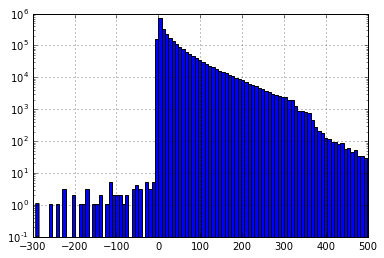

In [168]:
fig, ax = plt.subplots()
dataset["booking_span"].hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

In [115]:
vc = dataset["stay_span"].value_counts()

In [138]:
a = dataset["stay_span"].dropna().values

In [155]:
b = a[a>=1].astype('int16')

In [165]:
b.mean()+b.std()*3

10.068086851606267

In [166]:
sum(dataset["stay_span"]>10)

19592

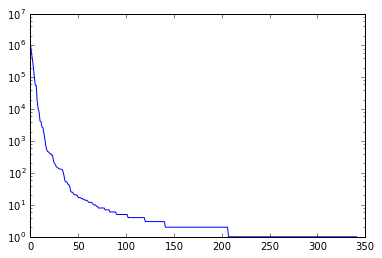

In [135]:
fig, ax = plt.subplots()
plt.plot(vc.values)
ax.set_yscale('log')

In [167]:
sum(dataset["stay_span"]==0)/2527610

0.00071292644039230738

In [ ]:
dataset["stay_span"]

In [100]:
col = 'stay_span'

In [84]:
dataset.loc[dataset[col] == int(special_year) , col]

Series([], Name: site_name, dtype: uint8)

In [169]:
dataset = train

In [170]:
bookings_dataset = dataset[dataset.is_booking==True]

In [171]:
bookings_dataset.min()

site_name                       2.0000
posa_continent                  0.0000
user_location_country           0.0000
user_location_region            0.0000
user_location_city              0.0000
orig_destination_distance       0.0056
user_id                         5.0000
is_mobile                       0.0000
is_package                      0.0000
channel                         0.0000
srch_adults_cnt                 0.0000
srch_children_cnt               0.0000
srch_rm_cnt                     0.0000
srch_destination_id             1.0000
srch_destination_type_id        0.0000
is_booking                      1.0000
cnt                             1.0000
hotel_continent                 0.0000
hotel_country                   0.0000
hotel_market                    0.0000
hotel_cluster                   0.0000
year                         2013.0000
month                           1.0000
day                             1.0000
ci_year                      2012.0000
co_year                  

In [172]:
bookings_dataset.max()

site_name                    5.300000e+01
posa_continent               4.000000e+00
user_location_country        2.390000e+02
user_location_region         1.027000e+03
user_location_city           5.650700e+04
orig_destination_distance    1.219917e+04
user_id                      1.198784e+06
is_mobile                    1.000000e+00
is_package                   1.000000e+00
channel                      1.000000e+01
srch_adults_cnt              9.000000e+00
srch_children_cnt            9.000000e+00
srch_rm_cnt                  8.000000e+00
srch_destination_id          6.510400e+04
srch_destination_type_id     9.000000e+00
is_booking                   1.000000e+00
cnt                          2.100000e+01
hotel_continent              6.000000e+00
hotel_country                2.120000e+02
hotel_market                 2.117000e+03
hotel_cluster                9.900000e+01
year                         2.014000e+03
month                        1.200000e+01
day                          3.100

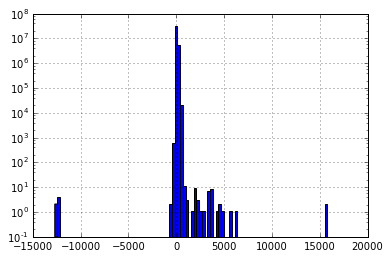

In [173]:
fig, ax = plt.subplots()
dataset["booking_span"].hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

In [211]:
train.loc[train["stay_span"]==0]

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,month,day,ci_year,co_year,ci_month,co_month,ci_day,co_day,stay_span,booking_span
1148,2,3,66,311,33705,2035.0555,6929,1,1,9,...,3.0,19.0,2014.0,2014.0,3.0,3.0,30.0,30.0,0.0,10.484375
1149,2,3,66,311,33705,2034.7570,6929,1,1,9,...,3.0,19.0,2014.0,2014.0,3.0,3.0,30.0,30.0,0.0,10.484375
1150,2,3,66,311,33705,2033.0260,6929,1,1,9,...,3.0,19.0,2014.0,2014.0,3.0,3.0,30.0,30.0,0.0,10.476562
1272,2,3,66,314,46561,928.2655,7041,1,1,9,...,11.0,3.0,2014.0,2014.0,12.0,12.0,10.0,10.0,0.0,36.343750
1353,2,3,66,174,17468,2397.1049,7283,0,1,2,...,7.0,24.0,2014.0,2014.0,11.0,11.0,16.0,16.0,0.0,114.062500
1358,2,3,66,174,17468,1169.0101,7283,0,1,0,...,8.0,7.0,2014.0,2014.0,11.0,11.0,14.0,14.0,0.0,98.062500
1641,2,3,66,226,47654,1708.6292,7783,0,1,0,...,1.0,13.0,2013.0,2013.0,3.0,3.0,31.0,31.0,0.0,76.187500
2041,24,2,3,50,5703,NaN,9582,0,1,1,...,1.0,9.0,2013.0,2013.0,1.0,1.0,12.0,12.0,0.0,2.583984
2424,2,3,66,442,46296,764.1521,10693,0,1,9,...,2.0,26.0,2014.0,2014.0,3.0,3.0,7.0,7.0,0.0,8.710938
3129,2,3,66,260,19022,1328.3353,15880,0,1,9,...,1.0,7.0,2013.0,2013.0,4.0,4.0,1.0,1.0,0.0,83.562500


In [212]:
sum(train.loc[train["stay_span"]==0].is_package==1)

143956

In [247]:
sum(train.loc[train["stay_span"]==0].is_package==1) / train.loc[train["stay_span"]==0].shape[0]

0.99414380818209447

In [251]:
test.loc[test["stay_span"]==0]

,id,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,month,day,ci_year,co_year,ci_month,co_month,ci_day,co_day,stay_span,booking_span
175,175,2,3,103,45,38784,NaN,725,0,0,...,6.0,11.0,2015.0,2015.0,8.0,8.0,30.0,30.0,0.0,79.375000
767,767,2,3,66,174,42284,7505.9175,2519,0,0,...,9.0,25.0,2015.0,2015.0,10.0,10.0,31.0,31.0,0.0,35.187500
1384,1384,2,3,66,462,27117,8030.6264,4514,0,0,...,11.0,9.0,2015.0,2015.0,11.0,11.0,18.0,18.0,0.0,8.335938
2231,2231,2,3,182,316,43264,212.7172,7153,0,0,...,7.0,6.0,2015.0,2015.0,7.0,7.0,9.0,9.0,0.0,2.457031
2247,2247,2,3,66,403,6674,4492.7798,7189,0,0,...,11.0,19.0,2015.0,2015.0,11.0,11.0,28.0,28.0,0.0,8.460938
3590,3590,24,2,3,50,5224,NaN,12133,0,0,...,8.0,31.0,2015.0,2015.0,9.0,9.0,20.0,20.0,0.0,20.000000
3631,3631,24,2,3,50,5224,NaN,12267,1,0,...,7.0,7.0,2015.0,2015.0,7.0,7.0,30.0,30.0,0.0,22.421875
9658,9658,2,3,146,379,8753,NaN,31750,0,0,...,12.0,13.0,2015.0,2015.0,12.0,12.0,30.0,30.0,0.0,16.718750
12518,12518,13,1,46,245,37877,0.8278,41859,0,0,...,6.0,16.0,2015.0,2015.0,6.0,6.0,24.0,24.0,0.0,7.378906
14106,14106,8,4,77,871,44584,229.2670,47667,0,0,...,5.0,22.0,2015.0,2015.0,5.0,5.0,31.0,31.0,0.0,8.296875


In [232]:
# mean is_package=1 in train-> 24%
# people who have a stay_span of 0 days -> 99% is_package=1
# people who have a stay_span of 1 day -> 4% is_package=1

In [226]:
train.loc[train["stay_span"]<0].shape[0]

798

In [ ]:
# 10,19600; 11,15400; 12,12600; 13, 9900; 14, 5800; 15, 5000; 16,4000; 

In [192]:
100*19592/2528243

0.7749255115113539

In [ ]:
# 450,870+ 145602

In [241]:
sum(train.is_package==1)/train.shape[0]

0.24890422275186444

In [242]:
sum(test.is_package==1)/test.shape[0]

0.10932532988324303

In [243]:
sum(train.loc[train["is_booking"]==1].is_package==1)/train.loc[train["is_booking"]==1].shape[0]

0.1366977561516623

In [244]:
sum(test.is_mobile==1)/test.shape[0]

0.14259784364082093

In [245]:
sum(train.is_mobile==1)/train.shape[0]

0.13492650561544611

In [5]:
# filename = train_as_hdf_smaller
# df.to_hdf(r"..\expedia_data\{0}.h5".format(filename),'train',format='fixed',mode='w', complevel=9,complib='bzip2')

In [3]:

filename = 'train_as_hdf'
train = pd.read_hdf(r"..\expedia_data\{0}.h5".format(filename))
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37670293 entries, 0 to 37670292
Data columns (total 32 columns):
site_name                    uint8
posa_continent               uint8
user_location_country        uint8
user_location_region         uint16
user_location_city           uint16
orig_destination_distance    float64
user_id                      uint32
is_mobile                    uint8
is_package                   uint8
channel                      uint8
srch_adults_cnt              uint8
srch_children_cnt            uint8
srch_rm_cnt                  uint8
srch_destination_id          uint32
srch_destination_type_id     uint8
is_booking                   uint8
cnt                          uint16
hotel_continent              uint8
hotel_country                uint8
hotel_market                 uint16
hotel_cluster                uint8
year                         float16
month                        float16
day                          float16
ci_year                      fl

In [6]:
filename = 'train_date_na_rows_removed'
train = pd.read_hdf(r"..\expedia_data\{0}.h5".format(filename))
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37623199 entries, 0 to 37670292
Data columns (total 24 columns):
date_time                    datetime64[ns]
site_name                    uint8
posa_continent               uint8
user_location_country        uint8
user_location_region         uint16
user_location_city           uint16
orig_destination_distance    float64
user_id                      uint32
is_mobile                    uint8
is_package                   uint8
channel                      uint8
srch_ci                      datetime64[ns]
srch_co                      datetime64[ns]
srch_adults_cnt              uint8
srch_children_cnt            uint8
srch_rm_cnt                  uint8
srch_destination_id          uint32
srch_destination_type_id     uint8
is_booking                   uint8
cnt                          uint16
hotel_continent              uint8
hotel_country                uint8
hotel_market                 uint16
hotel_cluster                uint8
dtypes: da

In [10]:
train["srch_ci"].min()

Timestamp('2012-02-15 00:00:00')

NameError: name 'Timestamp' is not defined

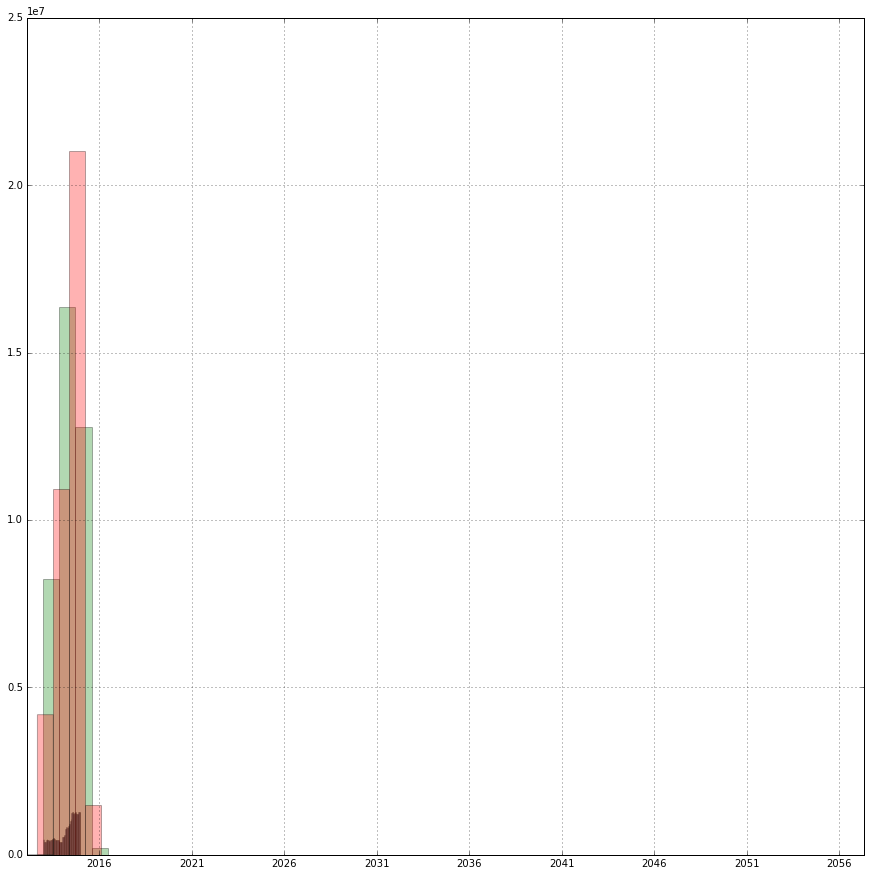

In [7]:
data = train
data["date_time"].hist(bins=52,alpha=.3,figsize=(15,15))
# plt.hist(data["date_time"].values,bins=52,alpha=.3,label = "date_time")
# #plt.hist(data["srch_ci"].values,bins=52,alpha=.3,label = "srch_ci")
# #plt.hist(data["srch_co"].values,bins=52,alpha=.3,label = "srch_co")
data["srch_ci"].hist(bins=52,alpha=.3)
data["srch_co"].hist(bins=52,alpha=.3)

In [7]:
filename = 'test_as_hdf'
test = pd.read_hdf(r"..\expedia_data\{0}.h5".format(filename))
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2528243 entries, 0 to 2528242
Data columns (total 22 columns):
id                           uint32
date_time                    datetime64[ns]
site_name                    uint8
posa_continent               uint8
user_location_country        uint8
user_location_region         uint16
user_location_city           uint16
orig_destination_distance    float64
user_id                      uint32
is_mobile                    uint8
is_package                   uint8
channel                      uint8
srch_ci                      datetime64[ns]
srch_co                      datetime64[ns]
srch_adults_cnt              uint8
srch_children_cnt            uint8
srch_rm_cnt                  uint8
srch_destination_id          uint32
srch_destination_type_id     uint8
hotel_continent              uint8
hotel_country                uint8
hotel_market                 uint16
dtypes: datetime64[ns](3), float64(1), uint16(3), uint32(3), uint8(12)
memory usag

In [20]:
# save version with no nans in srch_ci, srch_co

train.dropna(axis=0, how='any', subset=["srch_ci","srch_co"], inplace=True)

In [22]:
filename = 'train_date_na_rows_removed'

train.to_csv(r"..\expedia_data\{0}.csv".format(filename) , index=False)

In [26]:
train.to_hdf(r"..\expedia_data\{0}.h5".format(filename),'train',format='fixed',mode='w')


In [25]:
del(train)


GradientBoostingClassifier	 HTML	 KFold	 LinearRegression	 LogisticRegression	 RandomForestClassifier	 SelectKBest	 StandardScaler	 StratifiedKFold	 
a	 chunk	 chunk_pos	 col	 count	 cross_validation	 csv	 csv_chunks	 dataset	 
datasets	 date_columns	 datetime	 datetime_col_errors_dict	 datetime_col_errors_tup	 display	 dtypes_dict	 dtypes_dict_str	 el	 
end	 f	 f_classif	 filename	 gc	 init_type	 missing_date_values	 np	 num_types	 
operator	 output	 pd	 pickle	 plt	 re	 row_id	 start	 started	 
tables	 time	 train	 tup	 w	 


In [4]:
train_bookings_only = train[train.is_booking==True]

In [9]:
len(train_bookings_only)

3000693

In [6]:
filename = 'train_bookings_only'

train_bookings_only.to_csv(r"..\expedia_data\{0}.csv".format(filename) , index=False)
train_bookings_only.to_hdf(r"..\expedia_data\{0}.h5".format(filename),'train',format='fixed',mode='w')

In [11]:
filename = 'train_bookings_only'
train_bookings_only_test  = pd.read_csv( r"..\expedia_data\{0}.csv".format(filename) )
train_bookings_only_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000693 entries, 0 to 3000692
Data columns (total 24 columns):
date_time                    object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
hotel_cluster                int64
dtypes: float64(1), int64(20), object(3)
m

In [234]:
import gc
gc.collect()

0